## Word count analysis over time

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import pandas as pd
import os
from scipy.stats import pearsonr, spearmanr


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import CHAPTERS_DATA_TSV

In [2]:
def count_words(s: str):
    return len(s.split())

In [3]:
def words_per_second(row: pd.Series) -> float | None:
    n_words = row["word_count"]
    duration_s = row["duration_sec"]

    if pd.notna(duration_s) or pd.notna(n_words):
        return n_words / duration_s
    else:
        return None


def get_duration_sec(row: pd.Series) -> float | None:
    start_ms = row["start"]
    end_ms = row["end"]

    if pd.notna(start_ms) or pd.notna(end_ms):
        duration_sec = (float(end_ms) - float(start_ms)) / 1000
        return duration_sec
    else:
        return None

In [4]:
# Load chapters
tsv_file = Path(CHAPTERS_DATA_TSV).resolve()
df = pd.read_csv(tsv_file, sep="\t")

# Only data with timestamps
df = df[(df["start"].notna()) & (df["end"].notna())]
len(df)

2369

In [5]:
DF_COMBAT = df[(df["is_combat_scene"].notna()) & (df["is_combat_scene"])]
DF_WAR_REPORT = df[(df["is_war_report"].notna()) & (df["is_war_report"])]
DF_SOLDIERS = df[(df["german_soldiers_depicted"].notna()) & (df["german_soldiers_depicted"])]

In [6]:
df_description = "Chapters flagged as combat scenes"
df = DF_COMBAT

print(f"Data size: {len(df)}")

df["word_count"] = df["audio_transcription"].apply(count_words)
df["duration_sec"] = df.apply(lambda row: get_duration_sec(row), axis=1)
df["word_count_per_second"] = df.apply(lambda row: words_per_second(row), axis=1)

Data size: 751


In [7]:
df["word_count_per_minute"] = df["word_count_per_second"]*60
df["word_count_per_minute"].describe()

count    751.000000
mean      50.759238
std       24.311827
min        7.304348
25%       35.751347
50%       45.494505
75%       60.000000
max      205.714286
Name: word_count_per_minute, dtype: float64

In [8]:
df.sort_values("word_count_per_minute", ascending=False)
df[["audio_transcription", "word_count_per_minute"]]

,audio_transcription,word_count_per_minute
0,Der Reich ist in voller Schärfe entbrannt. Wie...,77.241379
1,Bombe für Bombe trifft ihr Ziel. Der rechte Fl...,57.142857
3,Im Somme-Gebiet sind heiße Kämpfe entbrannt. A...,31.673820
4,Fekin ist erreicht. Eine wichtige Etappe auf d...,68.571429
6,Weiter geht es auf La Hava zu. Straßensperren ...,59.104478
...,...,...
2473,Und Unruhen gehören zu den Tagesereignissen in...,111.428571
2478,"Das sind Aufnahmen aus der Marienburg, deren B...",152.307692
2479,"Der Befreier des Dutsche, Obersturmbannführers...",140.000000
2486,Hauptmann Akta vom Sprengkommando Berlin. Er e...,103.448276


In [9]:
x = df['episode']
y = df['word_count_per_minute']

pearson_r, pearson_p = pearsonr(x, y)
spearman_r, spearman_p = spearmanr(x, y)
mean = df["word_count_per_minute"].mean()
median = df["word_count_per_minute"].median()
std = df["word_count_per_minute"].std()
print(f"Median: {median:.2f}")
print(f"Mean: {mean:.2f}")
print(f"Standard deviation: {std:.2f}")
print(f"Pearson:\tr = {pearson_r}\tp={pearson_p}")
print(f"Spearman:\tr = {spearman_r}\tp={spearman_p}")


Median: 45.49
Mean: 50.76
Standard deviation: 24.31
Pearson:	r = 0.21816284354153032	p=1.526140671597177e-09
Spearman:	r = 0.24124813743280188	p=2.0921938030007678e-11


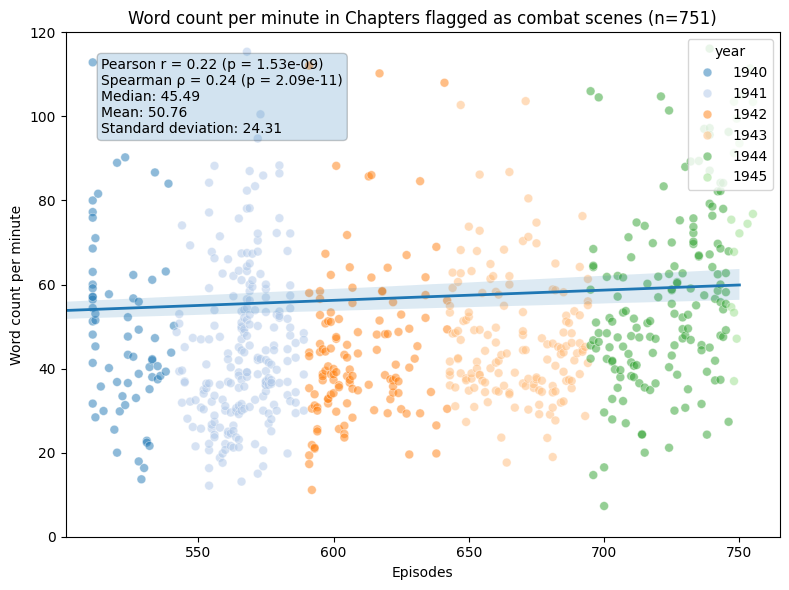

In [10]:
df_sorted = df.sort_values(["episode", "chapter"]).reset_index(drop=True)

text = (
    f"Pearson r = {pearson_r:.2f} (p = {pearson_p:.3g})\n"
    f"Spearman ρ = {spearman_r:.2f} (p = {spearman_p:.3g})\n"
    f"Median: {median:.2f}\n"
    f"Mean: {mean:.2f}\n"
    f"Standard deviation: {std:.2f}"
)

plt.figure(figsize=(8, 6))

ax = sns.scatterplot(
    data=df_sorted,
    x="episode",
    y="word_count_per_minute",
    hue="year",
    alpha=0.5,
    palette="tab20",
    legend="auto",
    s=40,
)

ax = sns.regplot(
    x=df_sorted.index,
    y=df_sorted["word_count_per_minute"],
    scatter=False,
    line_kws={"linewidth": 2},
)

plt.text(
    0.05,
    0.95,
    text,
    transform=plt.gca().transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", alpha=0.2),
)

plt.xlim(min(df["episode"]) - 10, max(df["episode"]) + 10)
plt.ylim(0, 120)
plt.xlabel("Episodes")
plt.ylabel("Word count per minute")
plt.title(f"Word count per minute in {df_description} (n={len(df_sorted)})")
sns.move_legend(ax, "upper right",bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()